## 라이브러리

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

<Axes: xlabel='time'>

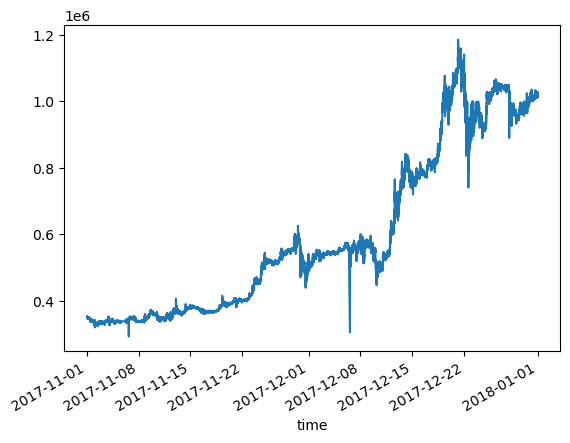

In [11]:
DATA_PATH = '.'
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

<Axes: xlabel='time'>

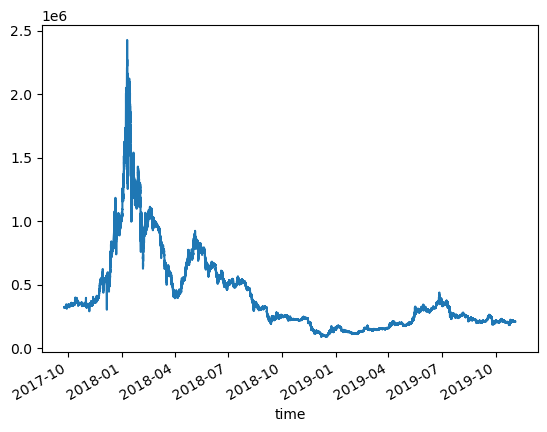

In [12]:
# 전체 데이터는 19년도까지
modify_data['close'].plot()

## 데이터 라벨링
### 추세를 라벨링 하는 4가지 방법
- Price Change Direction
- Using Moving Average
- Local Min-Max
- Trend Scanning

### Price Change Direction

In [13]:
# 과거 window=10 이전과 현재 가격을 비교해서 "올랐거나 유지"면 1, "떨어졌으면" 0이라는 라벨을 붙인 것
window = 10
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

Price Change Direction 할 때 왜 하필 2017-11-21일까?

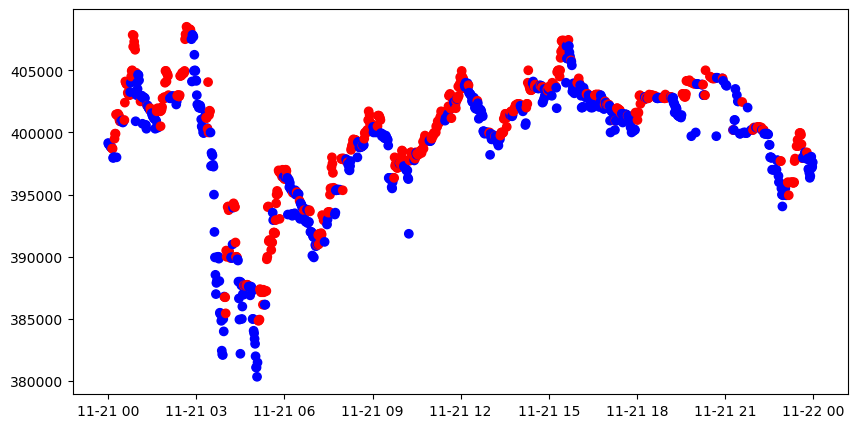

In [14]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [15]:
s_momentum_signal.head(15)

time
2017-09-25 03:00:00    NaN
2017-09-25 03:01:00    NaN
2017-09-25 03:02:00    NaN
2017-09-25 03:05:00    NaN
2017-09-25 03:06:00    NaN
2017-09-25 03:07:00    NaN
2017-09-25 03:10:00    NaN
2017-09-25 03:11:00    NaN
2017-09-25 03:12:00    NaN
2017-09-25 03:15:00    NaN
2017-09-25 03:16:00    0.0
2017-09-25 03:17:00    1.0
2017-09-25 03:20:00    0.0
2017-09-25 03:21:00    1.0
2017-09-25 03:22:00    0.0
Name: close, dtype: float64

### Using Moving Average

In [16]:
# modify_data['close'].rolling(window).mean() window: 크기만큼 이동 평균선 계산
# modify_data['close']: 현재 종가가 이동 평균보다 높은지 낮은지 비교하는 값
# np.sign(): >0 -> +1, <0 -> -1, ==0 -> 0 로 반환해주는 함수

momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

#### np.sign() 을 두 번 해주는 이유?  
-1, 0, 1 로 반환해주니까 이것을 0과 1로 압축해서 라벨링하기 위해.  
하락은 0 나머지는 1로 표현.

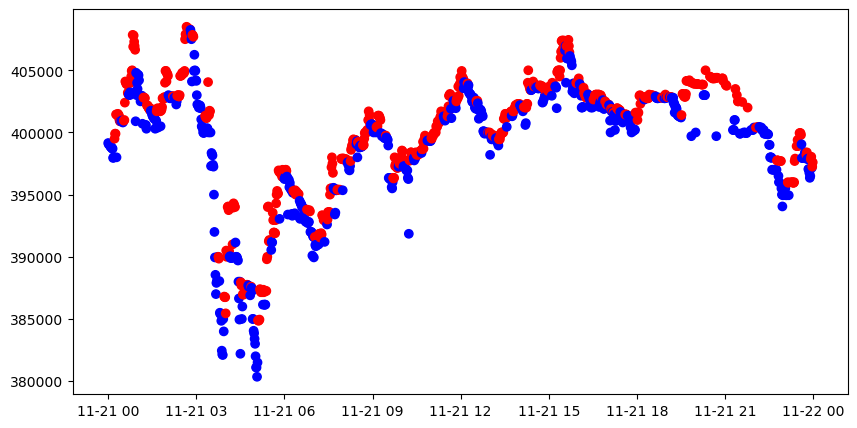

In [17]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = s_momentum_signal.loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

In [18]:
s_momentum_signal.head(15)

time
2017-09-25 03:00:00    NaN
2017-09-25 03:01:00    NaN
2017-09-25 03:02:00    NaN
2017-09-25 03:05:00    NaN
2017-09-25 03:06:00    NaN
2017-09-25 03:07:00    NaN
2017-09-25 03:10:00    NaN
2017-09-25 03:11:00    NaN
2017-09-25 03:12:00    NaN
2017-09-25 03:15:00    0.0
2017-09-25 03:16:00    0.0
2017-09-25 03:17:00    1.0
2017-09-25 03:20:00    0.0
2017-09-25 03:21:00    1.0
2017-09-25 03:22:00    0.0
Name: close, dtype: float64

### Local Min-Max

In [19]:
# Local min / max 를 추출하기 위한 함수
# 일정 시간 간격 기준으로 고점과 저점을 찾아 반환하는 함수
# wait=3: 최소/최대가 바뀌기까지 기다릴 최소 시간 (default=3)

def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
            
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [20]:
mins, maxes = get_local_min_max(sub_data, wait=3) # sub_data = 2017-11-21년 Close 데이터

(376546.5, 412585.0)

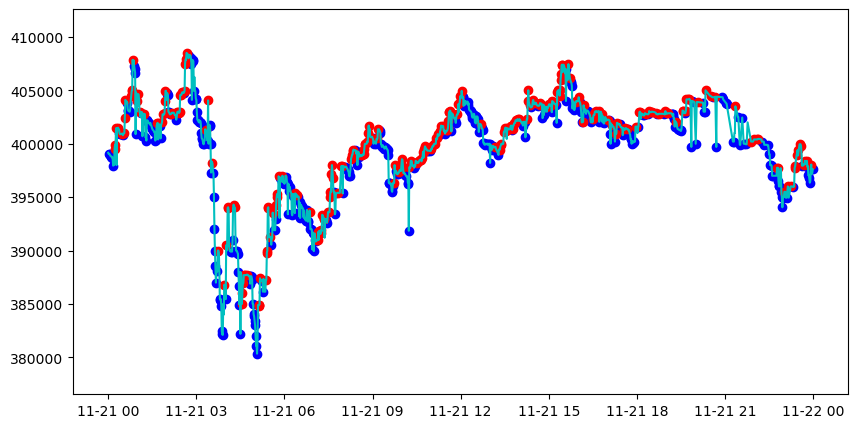

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')
ax.scatter(mins.min_time, mins.local_min, c='blue')
ax.scatter(maxes.max_time, maxes.local_max, c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00' 선택 이유?

(376546.5, 412585.0)

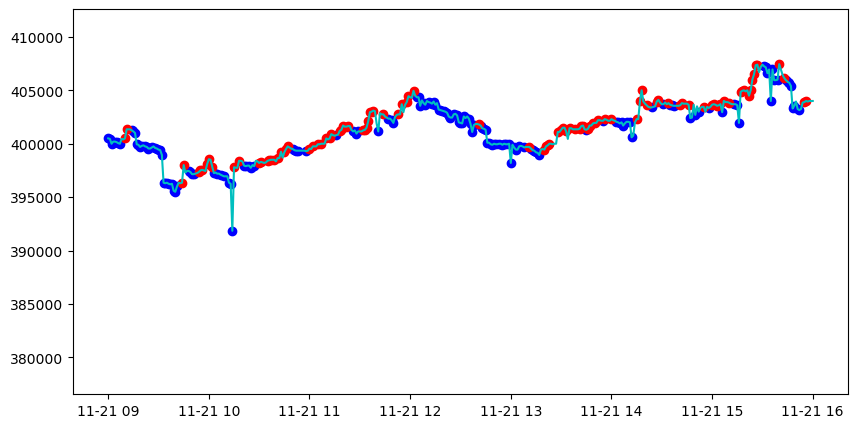

In [22]:
st_time, ed_time = '2017-11-21 09:00:00', '2017-11-21 16:00:00'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data.loc[st_time:ed_time], 'c')
ax.scatter(mins.set_index('min_time', drop=False).min_time.loc[st_time:ed_time], mins.set_index('min_time').local_min.loc[st_time:ed_time], c='blue')
ax.scatter(maxes.set_index('max_time', drop=False).max_time.loc[st_time:ed_time], maxes.set_index('max_time').local_max.loc[st_time:ed_time], c='red')
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

최대는 빨간색, 최소는 파란색으로 그래프 표현

In [23]:
mins

,min_time,local_min
0,2017-11-21 00:01:00,399050
1,2017-11-21 00:03:00,399000
2,2017-11-21 00:04:00,398900
3,2017-11-21 00:05:00,398850
4,2017-11-21 00:06:00,398800
...,...,...
472,2017-11-21 23:48:00,397850
473,2017-11-21 23:50:00,397050
474,2017-11-21 23:52:00,396750
475,2017-11-21 23:53:00,396350


In [24]:
mins.min()

min_time     2017-11-21 00:01:00
local_min                 380350
dtype: object

2017-11-21 00:01:00 이 가장 가격이 낮았던 시점이다.  

In [25]:
# 극소/극대 포인트 합치기
extrema_df = pd.concat([
    mins.rename(columns={'min_time': 'time', 'local_min': 'value'}).assign(type='min'),
    maxes.rename(columns={'max_time': 'time', 'local_max': 'value'}).assign(type='max')
])

# 시간 순으로 정렬
extrema_df = extrema_df.sort_values(by='time').reset_index(drop=True) # 시간 기준으로 오름차

# 각 구간의 변화 방향 라벨링
trend_labels = []
for i in range(len(extrema_df) - 1):
    current_val = extrema_df.loc[i, 'value']
    next_val = extrema_df.loc[i+1, 'value']
    label = 1 if next_val > current_val else 0 # 다음 값이 더 크면 1, 아니면 0으로 라벨
    trend_labels.append(label)

# 마지막 포인트는 다음 값이 없으므로 라벨 없음 → NaN 또는 0 처리
trend_labels.append(0)

# 최종 결과
extrema_df['label'] = trend_labels
print(extrema_df.head(15))


                  time   value type  label
0  2017-11-21 00:01:00  399050  min      0
1  2017-11-21 00:03:00  399000  min      0
2  2017-11-21 00:04:00  398900  min      0
3  2017-11-21 00:05:00  398850  min      0
4  2017-11-21 00:06:00  398800  min      0
5  2017-11-21 00:07:00  398800  min      0
6  2017-11-21 00:08:00  398700  min      0
7  2017-11-21 00:10:00  397950  min      1
8  2017-11-21 00:13:00  399500  max      1
9  2017-11-21 00:14:00  399900  max      1
10 2017-11-21 00:16:00  401450  max      0
11 2017-11-21 00:19:00  401350  max      1
12 2017-11-21 00:20:00  401500  max      0
13 2017-11-21 00:23:00  401000  min      0
14 2017-11-21 00:24:00  400900  min      0


1. 극소점과 극대점을 한 데이터프레임으로 합쳐서 시간순으로 볼 수 있게 함  
2. 두 극값 사이 구간에서 가격이 상승했는지 하락했는지를 구분하여 추세 방향을 앎 -> 이 정보를 바탕으로 매수/매도 신호, 리스크 관리 등  
3. 데이터 단순화 및 요약
4. 모델 학습용 라벨링로써 target label로 쓰임

### Trend Scanning

In [26]:
# 시계열 데이터에 대해 선형 추세가 통계적으로 유의미한지(t-value)를 계산하는 함수
# 주어진 close 시계열에 대해 시간에 따른 선형회귀를 하고 
# 기울기(추세)의 통계적 유의성을 나타내는 t-값 반환하는 함수
# t-값 절댓값이 클수록 추세가 명확하다는 의미

def t_val_lin_r(close):
    import statsmodels.api as sml

    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0]) 
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [27]:
look_forward_window = 60 # 이후 데이터 60개
min_sample_length = 5 # 최소 5개 데이터 이상 구간부터 분석 시
step = 1
t1_array = []
t_values_array = []

In [29]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # 계산 결과를 저장

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|████████████████████████████████████████████████████████████████████████████| 33384/33384 [31:17<00:00, 17.79it/s]


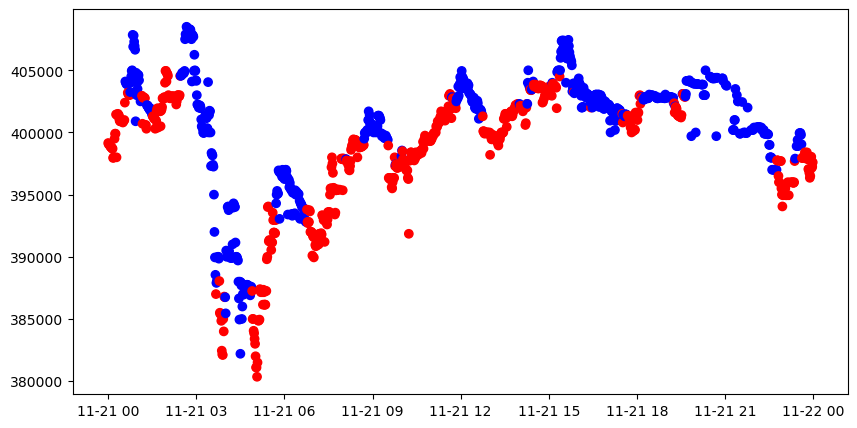

In [30]:
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

In [31]:
label.head(20)

,t1,t_val,bin
time,,,
2017-11-01 00:05:00,2017-11-01 06:10:00,-6.373987,-1
2017-11-01 00:12:00,2017-11-01 06:16:00,-6.273936,-1
2017-11-01 00:18:00,2017-11-01 06:23:00,-5.897474,-1
2017-11-01 00:24:00,2017-11-01 06:29:00,-5.425023,-1
2017-11-01 00:31:00,2017-11-01 06:35:00,-5.08177,-1
2017-11-01 00:37:00,2017-11-01 06:42:00,-4.895976,-1
2017-11-01 00:43:00,2017-11-01 06:48:00,-5.11334,-1
2017-11-01 00:50:00,2017-11-01 06:54:00,-4.866885,-1
2017-11-01 00:56:00,2017-11-01 07:00:00,-3.673143,-1


- time: 이 시점을 기준으로 이후 60개 시점까지의 종가를 보고 추세 평가
- t1: 시점을 기준으로 이후 60개 시점까지의 종가 중 가장 뚜렷한 추세를 보인 시점
- t_val: 절댓값이 클수록 추세가 강하다고 판단. +-> 상승 추세, --> 하락 추세
- bin: t_val 의 부호만을 이용해 추세 방향 라벨링
  
변동성 큰 시계열에서 실제 의미 있는 추세가 무엇인지 통계적으로 검증해 뽑아내고(=t-value),  
그 신뢰성 높은 방향 정보를 미래 판단 신호로 사용하는 것

## 데이터 가공하기
- 피처 추출
- 데이터 전처리

### 패키지 설치 및 데이터 불러오기

In [32]:
# !pip install ta==0.9.0
# !pip install shap

In [33]:
import sys
!{sys.executable} -m pip install ta==0.9.0
!{sys.executable} -m pip install shap

In [34]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys

from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

In [35]:
"""
mlfinlab
"""

"""
Module which implements feature importance algorithms as described in Chapter 8 of Advances in Financial Machine
Learning and Clustered Feature Importance algorithms as described in Chapter 6 Section 6.5.2 of Machine Learning for
Asset Managers.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss


def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

In [36]:
DATA_PATH = '.'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
# .pkl은 파이썬의 자료형을 바이너리로 변환한 파일

target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

## 데이터 전처리
### 학습 데이터셋 만드는 과정
.csv 와 .pkl 파일을 각각 불러와서 라벨이 있는 데이터만 골라내어, 1000개만 사용하는 코드

In [37]:
# df_modify_data 원본 데이터
# df_label_data 가격 변화에 따른 라벨 데이터
# df_sub_modify_data 라벨 시점에 맞춘 가격 데이터만 추출

df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옴
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

In [38]:
df_sub_modify_data.head()

,open,high,low,close,volume
time,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404


In [39]:
df_label_data.head(), df_label_data.tail()

(time
 2018-01-01 00:00:00   -0.0
 2018-01-01 00:01:00   -0.0
 2018-01-01 00:02:00   -0.0
 2018-01-01 00:03:00   -1.0
 2018-01-01 00:04:00   -1.0
 Name: t_value, dtype: float64,
 time
 2019-11-03 10:29:00   NaN
 2019-11-03 10:30:00   NaN
 2019-11-03 10:31:00   NaN
 2019-11-03 10:32:00   NaN
 2019-11-03 10:33:00   NaN
 Name: t_value, dtype: float64)

In [40]:
df_label_data.value_counts()

t_value
-1.0    306636
-0.0    302963
 1.0    299289
Name: count, dtype: int64

### Technical Index
- 기술적 지표
- 수익률/변동성 지표

#### 기술적 지표

In [41]:
mt = 1
fillna = False # 결측치 제거 x
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index 거래량 관련
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend 
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index 변동성
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index 추세 관련
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index 탄력성
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [42]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


#### 수익률/변동성 지표

In [43]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [44]:
# 결과 확인
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [45]:
df_tmp_data = df_.join(df_label_data).dropna()
X, y = df_tmp_data.iloc[:, 5:-1], df_tmp_data.iloc[:, -1]

sc = StandardScaler() # 스케일링
X_sc = sc.fit_transform(X) # 표준화 진행
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

기술적 지표 데이터와 레이블을 합치고 결측치 제거  
모델 학습에 사용할 X,y 분리  
X에 대해서 스케일링 수행하여 모델 학습 시 성능과 안정성 향상 

In [46]:
X_sc.head()

,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1.035464,-0.186753,0.065427,0.391695,0.143181,1.474065,0.054076,0.103695,0.930692,-0.078062,...,-0.141586,0.073599,-0.268825,-0.053926,-0.273922,-0.077989,-0.359687,0.617241,-0.335632,0.273404
2018-01-01 00:44:00,1.054026,0.125880,-0.011156,0.814123,0.544363,1.478520,0.017250,0.639945,0.771813,-0.051294,...,0.344922,1.111779,-0.209690,2.237163,-0.263511,0.036043,-0.266915,0.940844,-0.262646,0.291664
2018-01-01 00:45:00,1.042978,-0.023653,0.063195,1.052689,0.218332,1.290057,-0.020738,0.714133,0.598850,-0.015958,...,0.067032,0.544625,-0.124252,0.554780,-0.278339,0.150308,-0.252720,0.942325,-0.237456,0.301886
2018-01-01 00:46:00,1.016133,0.880060,-0.281931,0.928143,1.068429,1.633699,-0.020738,1.434675,0.454452,0.071047,...,0.783648,1.457839,0.168697,2.536405,-0.228841,0.833801,-0.227291,1.672326,-0.022928,0.256716
2018-01-01 00:47:00,0.893440,0.486864,-0.562722,-0.026395,0.862103,1.942977,0.088583,0.921217,0.319680,0.131133,...,-0.191611,-0.257415,-0.080204,0.402681,-0.380178,0.036276,-0.340320,0.454122,-0.018291,0.317671


In [47]:
X_sc.shape

(957, 23)

In [48]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## 피처 선택 기법
① Feature Selection
- MDI
- MDA

② Sequential Feature Selection
- RFE CV
- SFS

③ Shapley Additive explanations
- SHAP

#### MDI

In [49]:
# imp. 제거
# feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp = mean_decrease_impurity(rfc, X.columns)

In [50]:
feat_imp

,mean,std
volume_cmf,0.050096,0.002435
volume_fi,0.041915,0.002231
volume_mfi,0.042745,0.002243
volume_sma_em,0.040261,0.001998
volume_vpt,0.023168,0.001368
volatility_atr,0.070667,0.003132
volatility_ui,0.048264,0.002270
trend_macd_diff,0.087604,0.004111
trend_adx,0.049519,0.001993
trend_trix,0.075486,0.003106


MDA

In [51]:
svc_rbf = SVC(kernel='rbf', probability=True)
cv = KFold(n_splits=5)
feat_imp_mda = mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [52]:
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

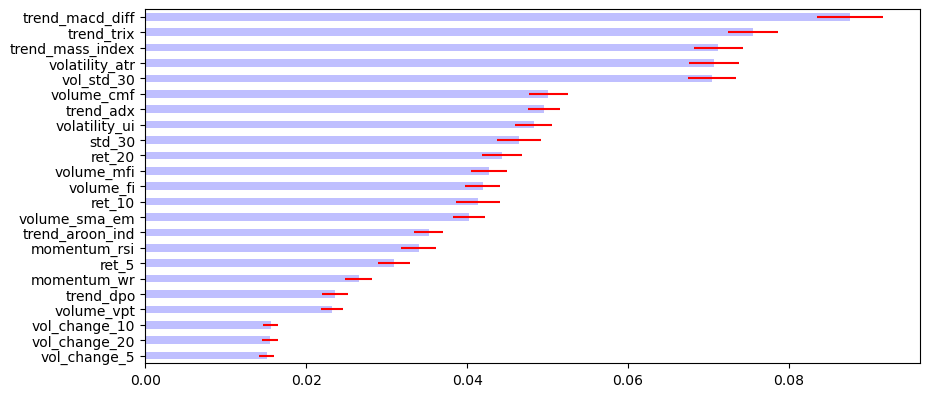

In [53]:
# volatility_atr : 시장의 변동성(진폭)을 측정하는 지표
# Average True Range (ATR)
plot_feature_importance(feat_imp)

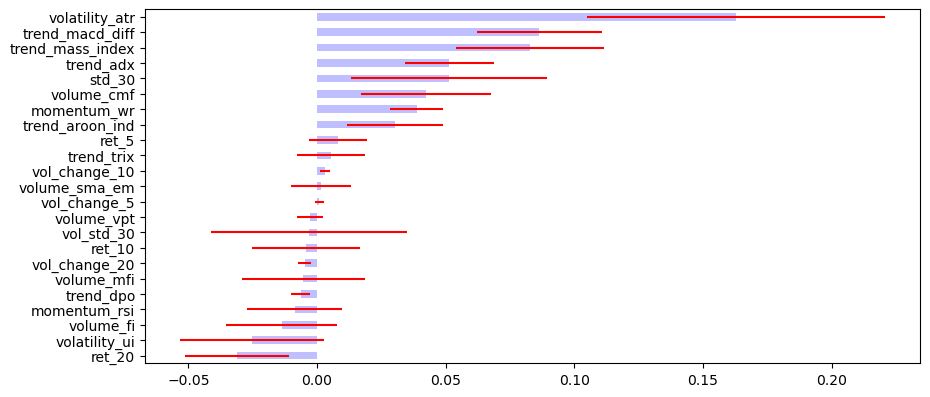

In [54]:
plot_feature_importance(feat_imp_mda)

`volatility_atr` 기술적 지표가 모델 예측에 가장 큰 영향을 준다는 의미다.

RFE CV

In [55]:
svc_rbf = SVC(kernel='linear', probability=True)
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [56]:
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,12
volume_fi,False,4
volume_mfi,False,14
volume_sma_em,False,7
volume_vpt,False,8
volatility_atr,True,1
volatility_ui,False,11
trend_macd_diff,True,1
trend_adx,False,19
trend_trix,False,10


In [57]:
rfe_df[rfe_df["Optimal_Features"]==True] # 최종적으로 선택된 중요한 처처

,Optimal_Features,Ranking
volatility_atr,True,1
trend_macd_diff,True,1
std_30,True,1


#### SFS

In [58]:
n = 2 # 중요한 피처 2개 선택

sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [59]:
sfs_rank = sfs_fitted.get_support()

# 최신 버전은 {} 대신 []를 사용해야함
#sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={"Optimal_Features"})
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

'volume_mfi', 'trend_macd_diff' 가 선택되었다.

SHAP

In [60]:
import shap
# 모델 output을 raw로 바꿔주기
explainer = shap.TreeExplainer(rfc, model_output="raw")
shap_value = explainer.shap_values(X_sc)

In [61]:
shap_value.shape # (샘플 수, 피처 수, 클래스 수)

(957, 23, 3)

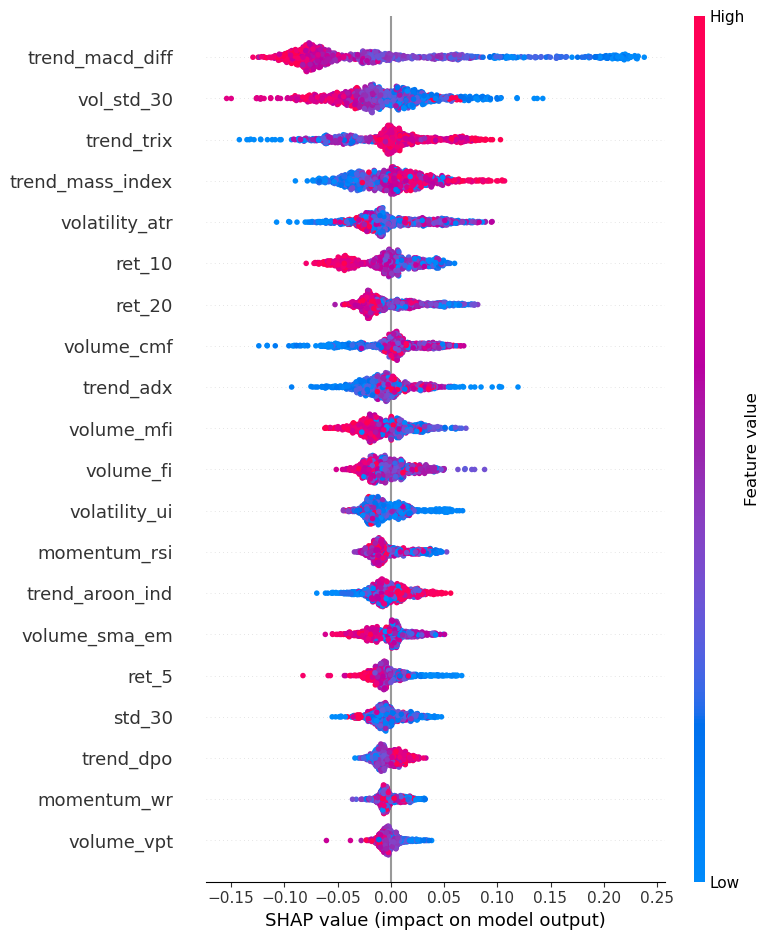

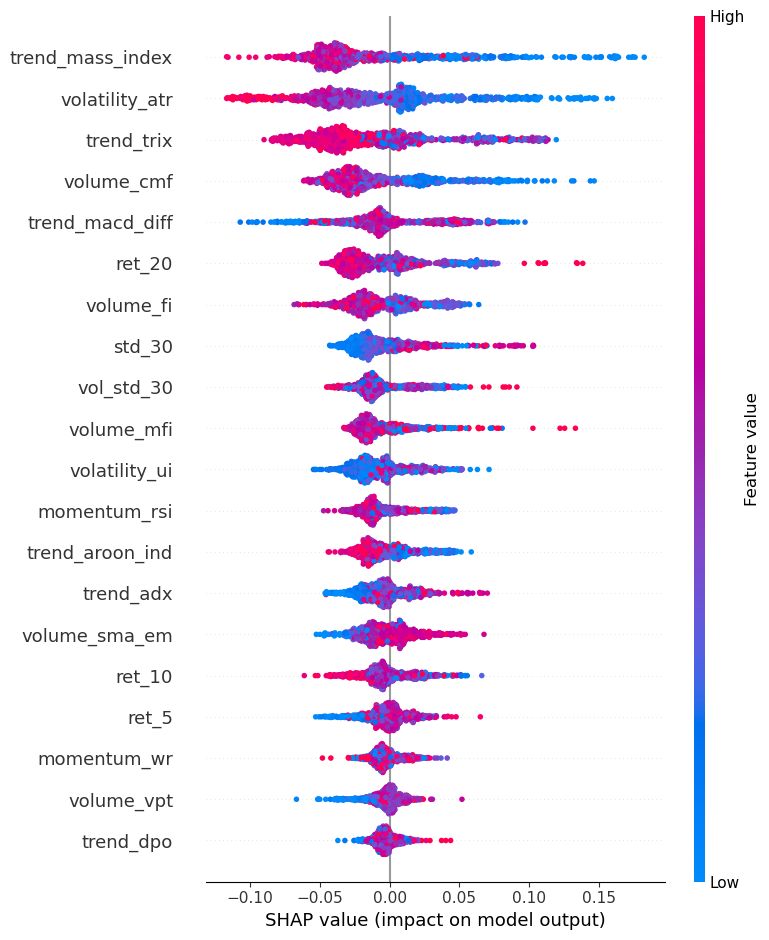

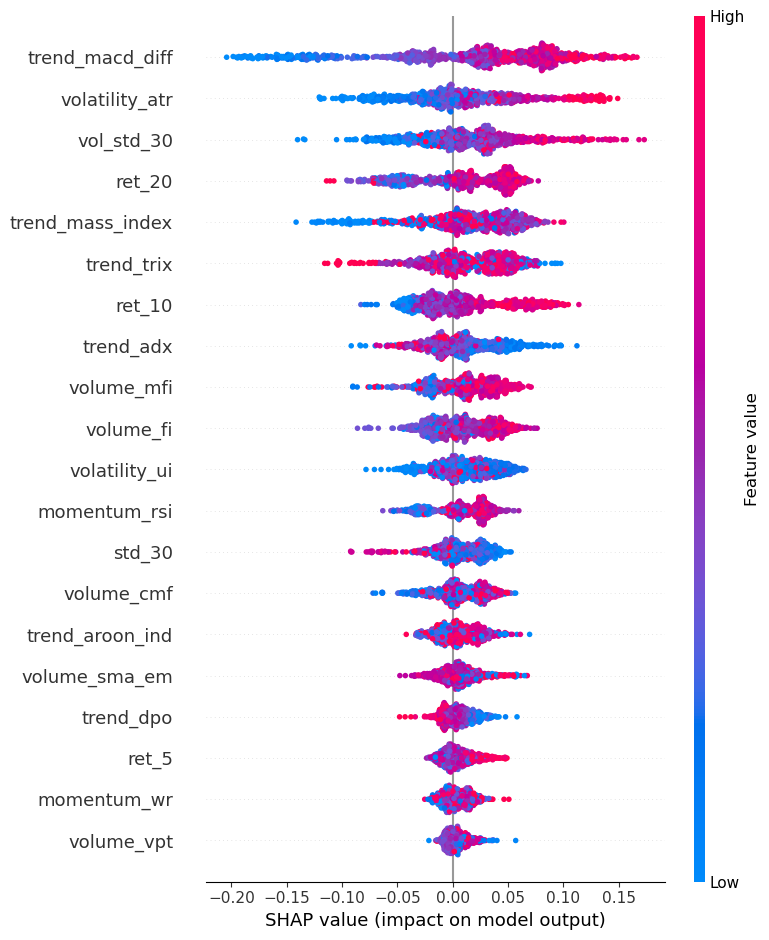

In [62]:
# 각 클래스별로 피처들이 해당 클래스 예측에 얼마나 기여하는지
#어떤 피처들이 해당 클래스 예측에 가장 큰 영향을 주는지
# 피처 값이 클 때와 작을 때 영향력이 어떻게 달라지는지

# 클래스 0에 대한 SHAP summary plot
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0')

# 클래스 1
shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1')

# 클래스 2
shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2')

In [63]:
# 절댓값 평균으로 전체 feature 중요도 요약
# 전체적으로 가장 영향력 있는 피처가 무엇인지

mean_shap = np.mean(np.abs(shap_value), axis=(0, 2)) 
shap_df = pd.Series(mean_shap, index=X_sc.columns).sort_values(ascending=False)
print(shap_df)

trend_macd_diff     0.056194
volatility_atr      0.036542
trend_mass_index    0.034957
trend_trix          0.032611
vol_std_30          0.029209
ret_20              0.027240
volume_cmf          0.022982
ret_10              0.022181
volume_mfi          0.019796
volume_fi           0.019690
trend_adx           0.019047
volatility_ui       0.018466
momentum_rsi        0.017087
std_30              0.016495
trend_aroon_ind     0.014497
volume_sma_em       0.013420
ret_5               0.010992
trend_dpo           0.008895
momentum_wr         0.008824
volume_vpt          0.007392
vol_change_20       0.003246
vol_change_10       0.003180
vol_change_5        0.002997
dtype: float64


특히 추세 지표(MACD 등)와 변동성 지표(ATR 등)가 가장 큰 영향력을 가진다는 점에서,  
이 지표들을 중심으로 시장의 방향성과 리스크(변동성)를 판단해 분류/예측을 수행한다고 볼 수 있다.

In [64]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)

## MODEL TRAINING

## 라이브러리

In [65]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

In [66]:
"""
Created on Fri Dec  6 19:41:30 2019

@author: sukji
"""
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

## 데이터 불러오기

In [67]:
DATA_PATH = '.'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

In [68]:
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [69]:
df_data

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,t_value
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:43:00,1017500,1019000,1017500,1018500,30.272135,0.363435,719.550725,56.072055,8.940793e+11,0.036253,...,-42.105263,-0.678913,0.000000,-0.318982,0.000000,-0.818597,0.004438,2348.636190,34.165561,1.0
2018-01-01 00:44:00,1018500,1021500,1018000,1021500,25.131162,0.368141,10053.792799,54.776628,2.480511e+12,0.103776,...,-10.526316,-0.294524,0.007396,-0.266406,0.000490,-0.363379,0.006404,2465.217810,34.384398,1.0
2018-01-01 00:45:00,1021500,1022000,1020000,1020000,17.108609,0.365340,5589.204549,56.034287,3.376449e+12,0.048901,...,-27.777778,0.260837,0.001965,-0.341287,0.000981,-0.293731,0.006413,2505.453821,34.506907,1.0
2018-01-01 00:46:00,1020000,1025000,1019000,1025000,44.289130,0.358534,32571.260299,50.196394,2.908715e+12,0.191981,...,-0.000000,2.165060,0.008362,-0.091323,0.003918,-0.168955,0.010848,2848.118960,33.965563,1.0
2018-01-01 00:47:00,1020000,1020000,1019000,1019000,10.224255,0.327429,20831.661354,45.446741,-6.760619e+11,0.157254,...,-52.173913,0.547160,0.001474,-0.855580,0.000491,-0.723566,0.003447,2855.524994,34.696090,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,-0.000000,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354,0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,-62.500000,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774,0.0
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,-87.500000,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495,0.0


In [70]:
df_data['t_value'].value_counts()

t_value
1.0    481
0.0    476
Name: count, dtype: int64

In [71]:
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

In [72]:
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [73]:
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옴
train_x = train_x[:1000]
train_y = train_y[:1000]

## Purged K-fold for Cross-Validation

In [74]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

## Model 적용하기

### Find the best param for bagging(RandomForest) with grid-search

In [129]:
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }

rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_
print(gs_rfc_best)

Fitting 4 folds for each of 288 candidates, totalling 1152 fits
BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=20,
                                                   max_features=None,
                                                   min_samples_leaf=10),
                  max_features=0.7)


In [130]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(bootstrap_features=True,
                  estimator=RandomForestClassifier(class_weight='balanced',
                                                   max_depth=20,
                                                   max_features=None,
                                                   min_samples_leaf=10),
                  max_features=0.7)

In [131]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [132]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[82 54]
 [ 7 48]]
정확도:0.680628272251309, 정밀도:0.47058823529411764, 재현율:0.8727272727272727


In [79]:
# ================= confusion matrix ====================
# [[79 57]
# [13 42]]
# =======================================================

In [80]:
# fpr, tpr, thresholds = roc_curve(test_y, pred_y)
# auc = roc_auc_score(test_y, pred_y)
# plt.plot(fpr, tpr, linewidth=2)
# plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
# plt.xlabel('fpr')
# plt.ylabel('tpr')
# print(f'auc:{auc}')

정확도:0.6335078534031413, 정밀도:0.42424242424242425, 재현율:0.7636363636363637  
auc:0.67225935828877

### XGBoost

In [81]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

auc:0.6209893048128342


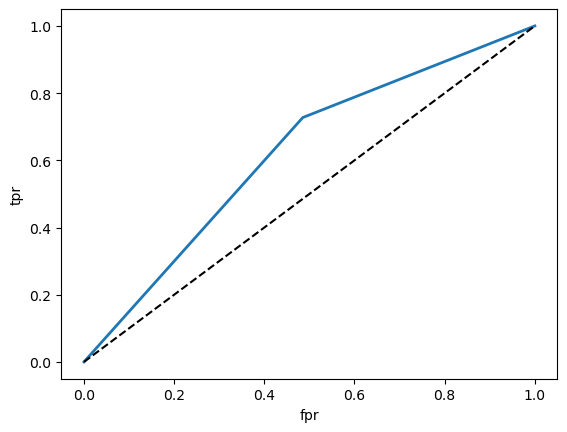

In [82]:
xgb.fit(train_x, train_y)
pred_y = xgb.predict(test_x)
prob_y = xgb.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

In [123]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_params = {
    'n_estimators': [100, 200,500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

gs_xgb = GridSearchCV(xgb, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_xgb.fit(train_x, train_y)
best_xgb = gs_xgb.best_estimator_
print(best_xgb)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)


auc:0.6339572192513369
================= confusion matrix ====================
[[76 60]
 [16 39]]
정확도:0.6020942408376964, 정밀도:0.3939393939393939, 재현율:0.7090909090909091


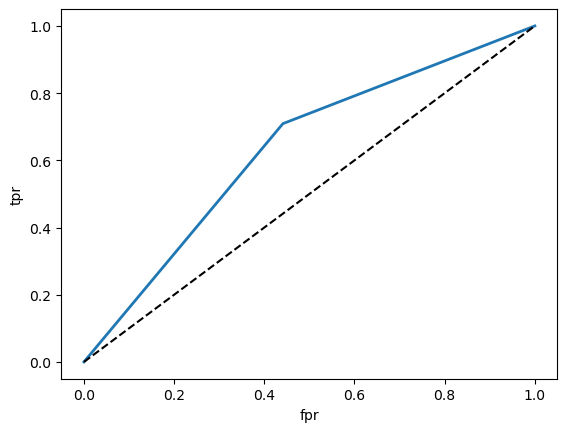

In [84]:
best_xgb.fit(train_x, train_y)
pred_y = best_xgb.predict(test_x)
prob_y = best_xgb.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

### LightGBM

In [85]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()

[LightGBM] [Info] Number of positive: 378, number of negative: 292
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4753
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564179 -> initscore=0.258140
[LightGBM] [Info] Start training from score 0.258140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


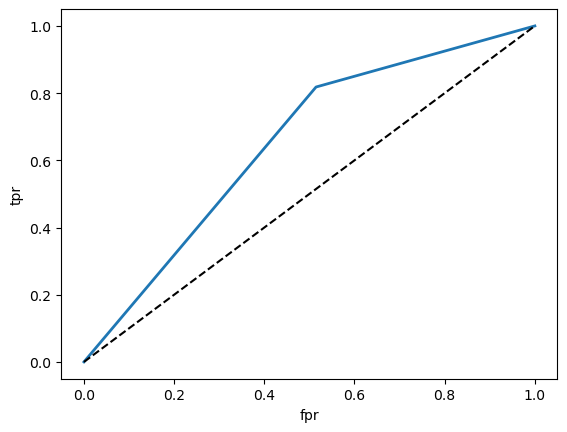

In [86]:
lgb.fit(train_x, train_y)
pred_y = lgb.predict(test_x)
prob_y = lgb.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [133]:
lgbm = LGBMClassifier(random_state=42)

lgbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

gs_lgbm = GridSearchCV(lgbm, lgbm_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_lgbm.fit(train_x, train_y)
best_lgbm = gs_lgbm.best_estimator_
print(best_lgbm)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Info] Number of positive: 378, number of negative: 292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4753
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564179 -> initscore=0.258140
[LightGBM] [Info] Start training from score 0.258140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Info] Number of positive: 378, number of negative: 292
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4753
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564179 -> initscore=0.258140
[LightGBM] [Info] Start training from score 0.258140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

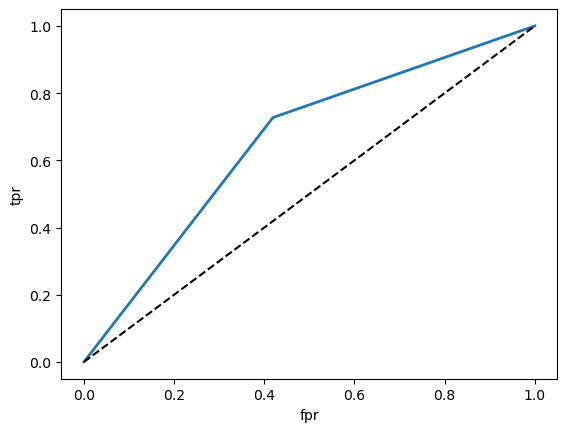

In [88]:
best_lgbm.fit(train_x, train_y)
pred_y = best_lgbm.predict(test_x)
prob_y = best_lgbm.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

### CatBoost

In [89]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [90]:
# pip list

In [91]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(verbose=0)

auc:0.653475935828877
================= confusion matrix ====================
[[64 72]
 [ 9 46]]
정확도:0.5759162303664922, 정밀도:0.3898305084745763, 재현율:0.8363636363636363


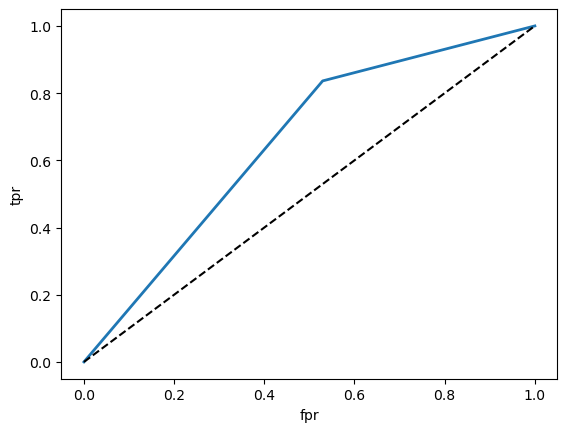

In [92]:
cat.fit(train_x, train_y)
pred_y = cat.predict(test_x)
prob_y = cat.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [134]:
cat = CatBoostClassifier(verbose=0, random_state=42)

cat_params = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

gs_cat = GridSearchCV(cat, cat_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_cat.fit(train_x, train_y)
best_cat = gs_cat.best_estimator_
print(best_cat)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


auc:0.6502005347593582
================= confusion matrix ====================
[[73 63]
 [13 42]]
정확도:0.6020942408376964, 정밀도:0.4, 재현율:0.7636363636363637


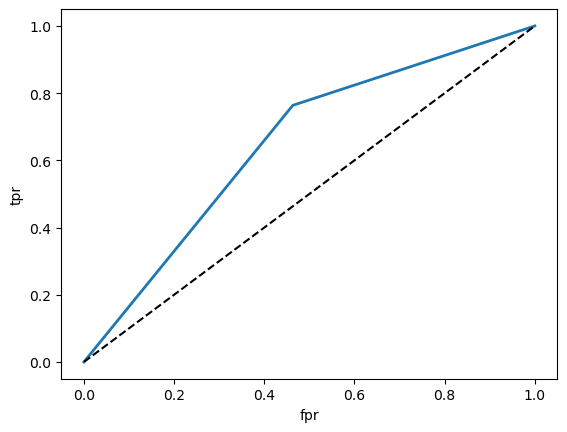

In [136]:
best_cat.fit(train_x, train_y)
pred_y = best_cat.predict(test_x)
prob_y = best_cat.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

### GradientBoostingClassifier

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

auc:0.6244652406417113
================= confusion matrix ====================
[[66 70]
 [13 42]]
정확도:0.5654450261780105, 정밀도:0.375, 재현율:0.7636363636363637


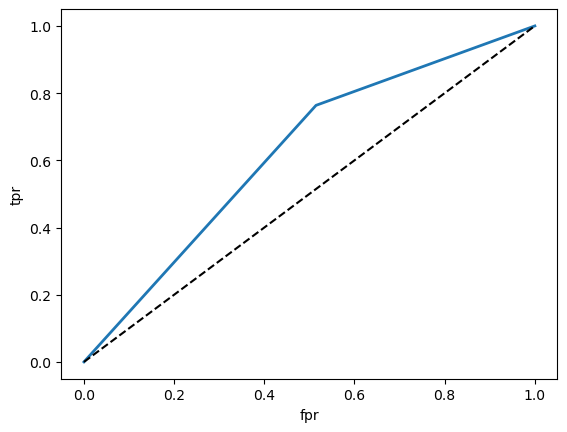

In [96]:
gbc.fit(train_x, train_y)
pred_y = gbc.predict(test_x)
prob_y = gbc.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [135]:
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gs_gb = GridSearchCV(gb, gb_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_gb.fit(train_x, train_y)
best_gb = gs_gb.best_estimator_
print(best_gb)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           random_state=42, subsample=0.8)


auc:0.6828877005347593
================= confusion matrix ====================
[[72 64]
 [ 9 46]]
정확도:0.6178010471204188, 정밀도:0.41818181818181815, 재현율:0.8363636363636363


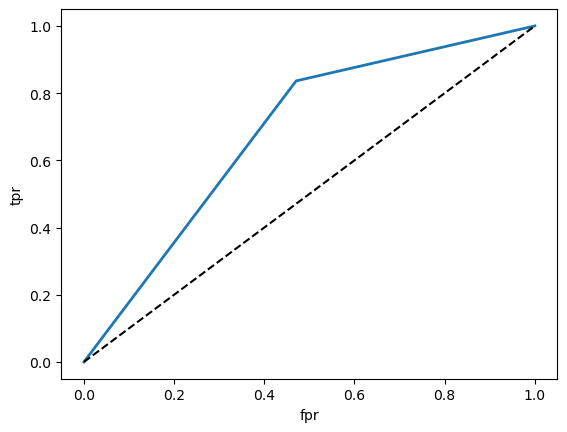

In [98]:
best_gb.fit(train_x, train_y)
pred_y = best_gb.predict(test_x)
prob_y = best_gb.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

### ExtraTreesClassifier

In [99]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

auc:0.695855614973262
================= confusion matrix ====================
[[78 58]
 [10 45]]
정확도:0.643979057591623, 정밀도:0.4368932038834951, 재현율:0.8181818181818182


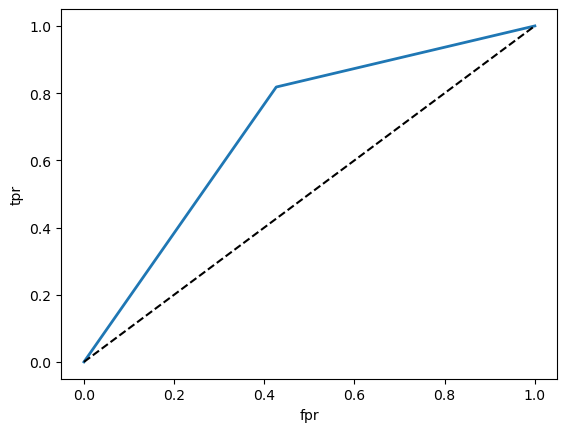

In [100]:
etc.fit(train_x, train_y)
pred_y = etc.predict(test_x)
prob_y = etc.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [119]:
et = ExtraTreesClassifier(random_state=42, class_weight='balanced')

et_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2', None]
}

gs_et = GridSearchCV(et, et_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_et.fit(train_x, train_y)
best_et = gs_et.best_estimator_
print(best_et)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
ExtraTreesClassifier(class_weight='balanced', max_depth=3, max_features=None,
                     min_samples_leaf=5, n_estimators=200, random_state=42)


auc:0.6906417112299466
================= confusion matrix ====================
[[84 52]
 [13 42]]
정확도:0.6596858638743456, 정밀도:0.44680851063829785, 재현율:0.7636363636363637


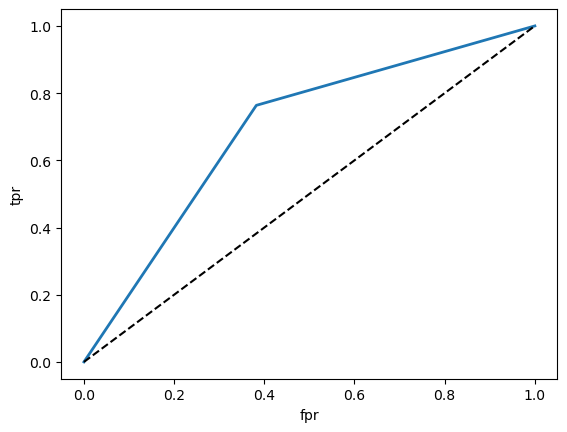

In [120]:
best_et.fit(train_x, train_y)
pred_y = best_et.predict(test_x)
prob_y = best_et.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

### DecisionTreeClassifier

auc:0.5973930481283423
================= confusion matrix ====================
[[71 65]
 [18 37]]
정확도:0.5654450261780105, 정밀도:0.3627450980392157, 재현율:0.6727272727272727


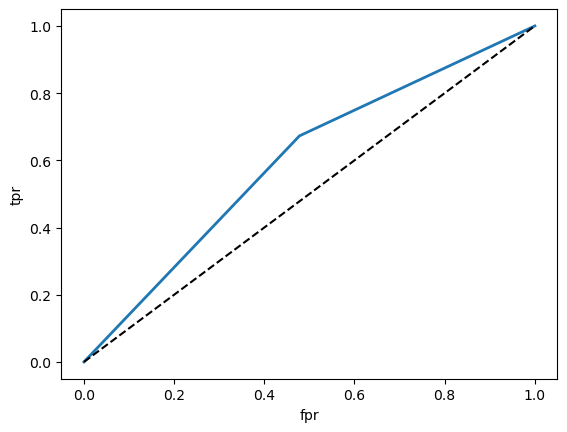

In [103]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0)

dt_clf.fit(train_x, train_y)
pred_y = dt_clf.predict(test_x)
prob_y = dt_clf.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [109]:
dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'max_depth': [2,3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

gs_dt = GridSearchCV(dt, dt_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_dt.fit(train_x, train_y)
best_dt = gs_dt.best_estimator_
print(best_dt)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)


auc:0.7304812834224599
================= confusion matrix ====================
[[80 56]
 [ 7 48]]
정확도:0.6701570680628273, 정밀도:0.46153846153846156, 재현율:0.8727272727272727


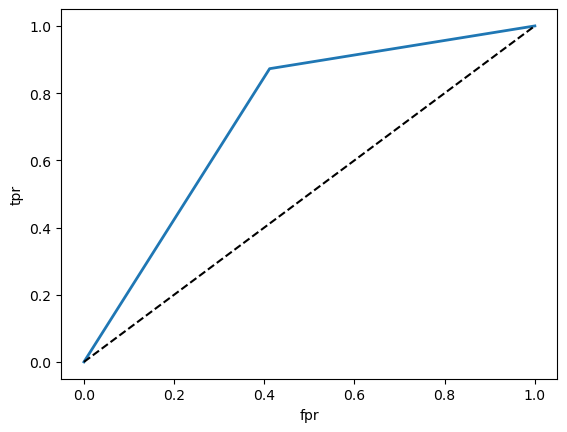

In [105]:
best_dt.fit(train_x, train_y)
pred_y = best_dt.predict(test_x)
prob_y = best_dt.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

### Stacking model

auc:0.7304812834224599
================= confusion matrix ====================
[[80 56]
 [ 7 48]]
정확도:0.6701570680628273, 정밀도:0.46153846153846156, 재현율:0.8727272727272727


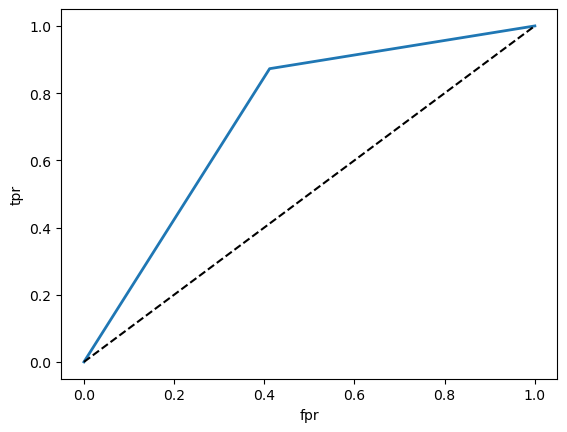

In [114]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3)),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier())
]

stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack_model.fit(train_x, train_y)
pred_y = best_dt.predict(test_x)
prob_y = best_dt.predict_proba(test_x)

confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

In [124]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# 베이스 모델 정의
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=5)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# 스태킹 모델 정의
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# 튜닝할 파라미터 설정 (final_estimator 위주로)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs', 'liblinear']
}

# GridSearchCV 적용
gs_stack = GridSearchCV(stack_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_stack.fit(train_x, train_y)

# 최적 모델
best_stack = gs_stack.best_estimator_
print("Best Params:", gs_stack.best_params_)

# 성능 평가
pred_y = best_stack.predict(test_x)
prob_y = best_stack.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, prob_y)
print("auc:", auc)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'final_estimator__C': 1, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}
ROC AUC: 0.8008021390374331


In [127]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# 베이스 모델 정의
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.01, use_label_encoder=False, eval_metric='logloss'))
]

# 스태킹 모델 정의
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# 튜닝할 파라미터 설정 (final_estimator 위주로)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs', 'liblinear']
}

# GridSearchCV 적용
gs_stack = GridSearchCV(stack_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_stack.fit(train_x, train_y)

# 최적 모델
best_stack = gs_stack.best_estimator_
print("Best Params:", gs_stack.best_params_)

# 성능 평가
pred_y = best_stack.predict(test_x)
prob_y = best_stack.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, prob_y)
print("auc:", auc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'final_estimator__C': 0.01, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}
ROC AUC: 0.7981283422459893


In [141]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# 베이스 모델 정의
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=None, min_samples_leaf=10, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.01, use_label_encoder=False, eval_metric='logloss'))
]

# 스태킹 모델 정의
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# 튜닝할 파라미터 설정 (final_estimator 위주로)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs', 'liblinear']
}

# GridSearchCV 적용
gs_stack = GridSearchCV(stack_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_stack.fit(train_x, train_y)

# 최적 모델
best_stack = gs_stack.best_estimator_
print("Best Params:", gs_stack.best_params_)

# 성능 평가
pred_y = best_stack.predict(test_x)
prob_y = best_stack.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, prob_y)
print("auc:", auc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'final_estimator__C': 0.1, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}
ROC AUC: 0.7502673796791444


In [128]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# 베이스 모델 정의
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ('xtcf', ExtraTreesClassifier(class_weight='balanced', max_depth=3, max_features=None, min_samples_leaf=5, n_estimators=200, random_state=42))
]

# 스태킹 모델 정의
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# 튜닝할 파라미터 설정 (final_estimator 위주로)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs', 'liblinear']
}

# GridSearchCV 적용
gs_stack = GridSearchCV(stack_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_stack.fit(train_x, train_y)

# 최적 모델
best_stack = gs_stack.best_estimator_
print("Best Params:", gs_stack.best_params_)

# 성능 평가
pred_y = best_stack.predict(test_x)
prob_y = best_stack.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, prob_y)
print("auc:", auc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'final_estimator__C': 0.01, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}
ROC AUC: 0.8227272727272728


In [142]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# 베이스 모델 정의
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('xtcf', ExtraTreesClassifier(class_weight='balanced', max_depth=3, max_features=None, min_samples_leaf=5, n_estimators=200, random_state=42))
]

# 스태킹 모델 정의
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# 튜닝할 파라미터 설정 (final_estimator 위주로)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs', 'liblinear']
}

# GridSearchCV 적용
gs_stack = GridSearchCV(stack_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_stack.fit(train_x, train_y)

# 최적 모델
best_stack = gs_stack.best_estimator_
print("Best Params:", gs_stack.best_params_)

# 성능 평가
pred_y = best_stack.predict(test_x)
prob_y = best_stack.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, prob_y)
print("auc:", auc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'final_estimator__C': 0.01, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}
auc: 0.8237967914438502


In [139]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# 베이스 모델 정의
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)),
    ('gbcf', GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt', random_state=42, subsample=0.8)),
    ('xtcf', ExtraTreesClassifier(random_state=42))
]

# 스태킹 모델 정의
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

# 튜닝할 파라미터 설정 (final_estimator 위주로)
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__penalty': ['l2'],
    'final_estimator__solver': ['lbfgs', 'liblinear']
}

# GridSearchCV 적용
gs_stack = GridSearchCV(stack_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_stack.fit(train_x, train_y)

# 최적 모델
best_stack = gs_stack.best_estimator_
print("Best Params:", gs_stack.best_params_)

# 성능 평가
pred_y = best_stack.predict(test_x)
prob_y = best_stack.predict_proba(test_x)[:, 1]
auc = roc_auc_score(test_y, prob_y)
print("auc:", auc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params: {'final_estimator__C': 0.01, 'final_estimator__penalty': 'l2', 'final_estimator__solver': 'lbfgs'}
auc: 0.8212566844919786
